In [1]:
# Cell 1: Imports & Configuration

import os
import copy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, mean_absolute_error, roc_auc_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# --- CONFIGURATION ---
# UPDATE THESE PATHS FOR YOUR LOCAL MACHINE
DATA_PATH = r'C:\Users\aatri\Downloads\archive (1)\Dev_data_to_be_shared.csv'
TEST_DATA_PATH = r"C:\Users\aatri\Downloads\archive (1)\validation_data_ti_be_shared.csv" 

RESULTS_DIR = "results_final_pipeline"
RANDOM_STATE = 42
TEST_SIZE = 0.20
N_SPLITS = 5 
PCA_VARIANCE = 0.95
MI_TOP_K = 500  

os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Environment setup complete. Results will be saved to: {RESULTS_DIR}")

Environment setup complete. Results will be saved to: results_final_pipeline


In [2]:
# Cell 2: Utility Functions

def optimize_dataframe(df):
    """Downcasts numeric columns to reduce memory usage."""
    print("  -> Optimizing memory...")
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if 'id' in col.lower() or 'account' in col.lower(): continue
        if pd.api.types.is_float_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif pd.api.types.is_integer_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

def sentinel_impute_with_flags(df):
    """Applies domain-aware sentinel imputation."""
    print("  -> Applying sentinel imputation...")
    df = df.copy()
    for col in df.columns:
        # Bureau: Missing likely means 'Thin File' (No credit history) -> Risk Factor
        if 'bureau' in col.lower() or 'onus' in col.lower():
            df[col + "_missing_flag"] = df[col].isna().astype(int)
            df[col] = df[col].fillna(-9999) # Safe sentinel distinct from real scores
        # Transaction: Missing likely means 'No Activity' -> 0
        elif 'transaction' in col.lower() or 'txn' in col.lower():
            df[col + "_missing_flag"] = df[col].isna().astype(int)
            df[col] = df[col].fillna(0)
        # General Numeric: Median
        elif pd.api.types.is_numeric_dtype(df[col]):
            df[col + "_missing_flag"] = df[col].isna().astype(int)
            df[col] = df[col].fillna(df[col].median())
    return df

def clone_estimator(est):
    return copy.deepcopy(est)

Loading Data...
Shape: (96806, 1216)


C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4252692957.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='bad_flag', data=df, palette='viridis')


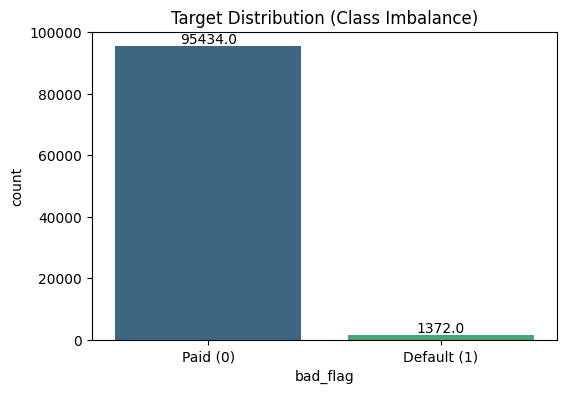

Class Ratio:
bad_flag
0    0.985827
1    0.014173
Name: proportion, dtype: float64


C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4252692957.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.index, y=missing.values, palette='magma')


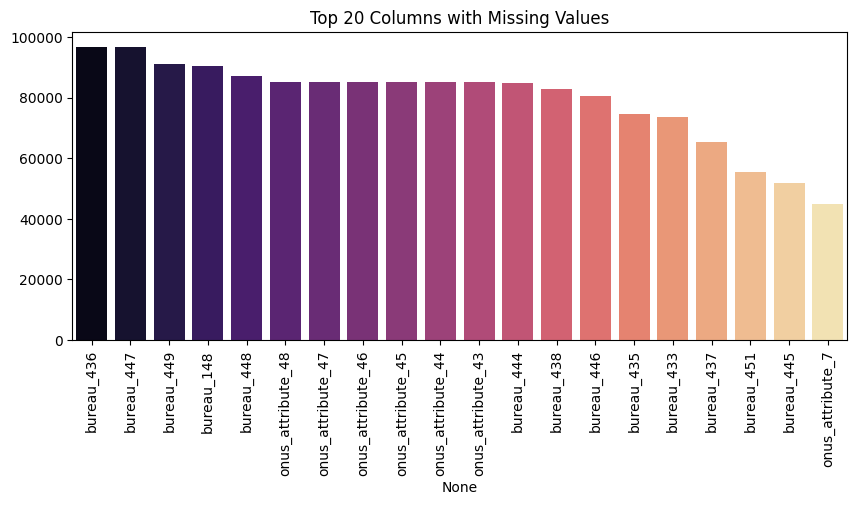

  -> Optimizing memory...
  -> Applying sentinel imputation...


In [3]:
# Cell 3: Load Data & Initial EDA

print("Loading Data...")
df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")

# 1. Check Class Imbalance (Validates 'Imbalanced Dataset' claim)
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='bad_flag', data=df, palette='viridis')
plt.title('Target Distribution (Class Imbalance)')
plt.xticks([0, 1], ['Paid (0)', 'Default (1)'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.show()

ratio = df['bad_flag'].value_counts(normalize=True)
print(f"Class Ratio:\n{ratio}")

# 2. Check Missingness (Validates Imputation Strategy)
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False).head(20)
if not missing.empty:
    plt.figure(figsize=(10, 4))
    sns.barplot(x=missing.index, y=missing.values, palette='magma')
    plt.xticks(rotation=90)
    plt.title('Top 20 Columns with Missing Values')
    plt.show()

# 3. Apply Optimization & Imputation
df = optimize_dataframe(df)
df = sentinel_impute_with_flags(df)

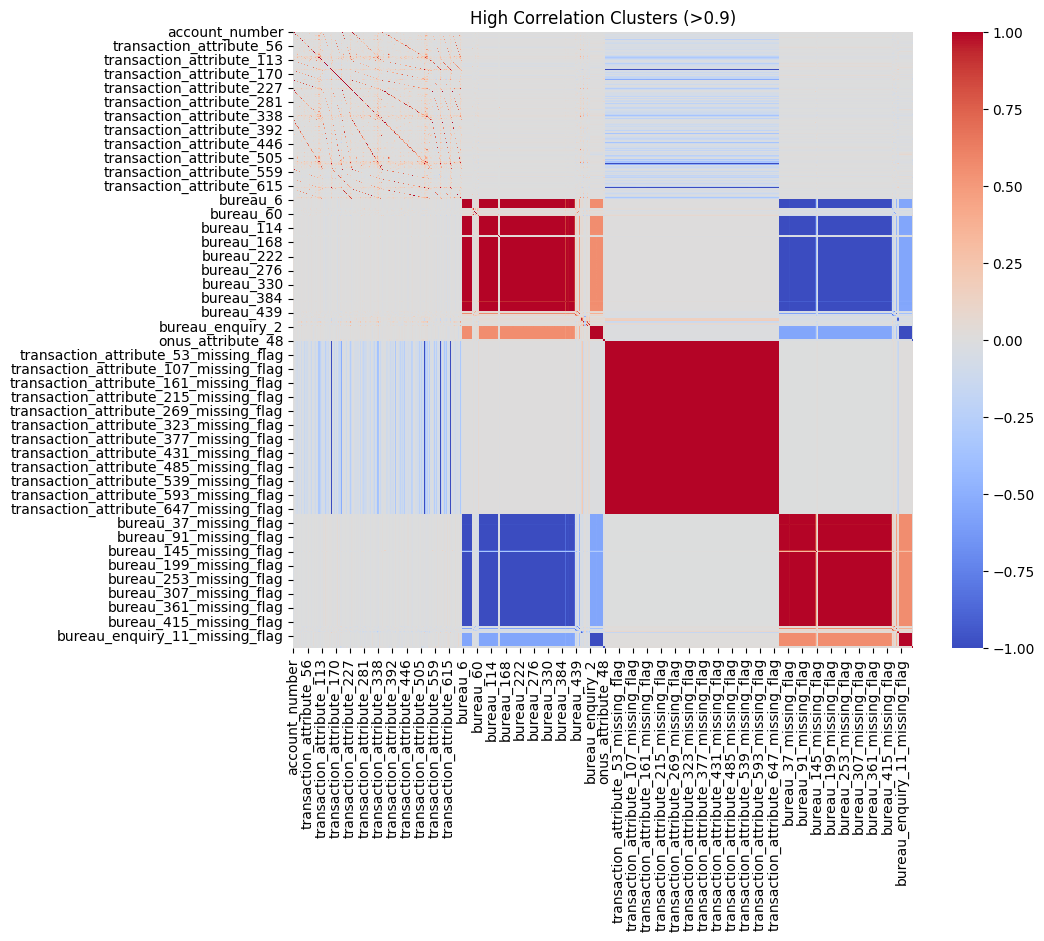

C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4260986348.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bad_flag', y=col, data=data_filtered, palette='Set2', showfliers=False)


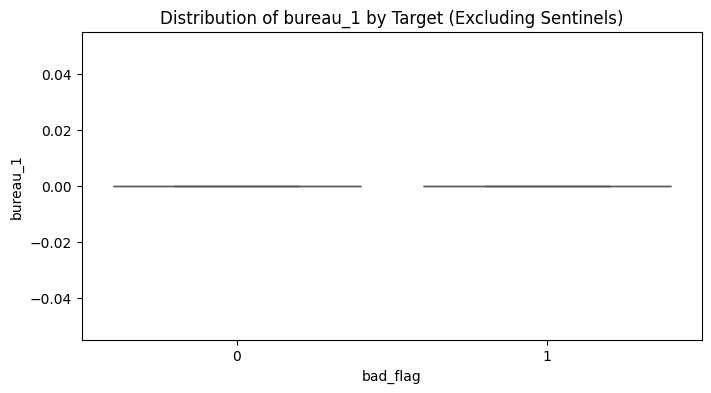

C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4260986348.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bad_flag', y=col, data=data_filtered, palette='Set2', showfliers=False)


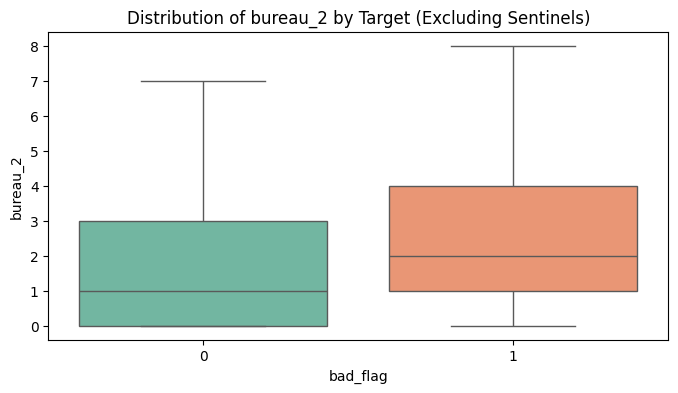

C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4260986348.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bad_flag', y=col, data=data_filtered, palette='Set2', showfliers=False)


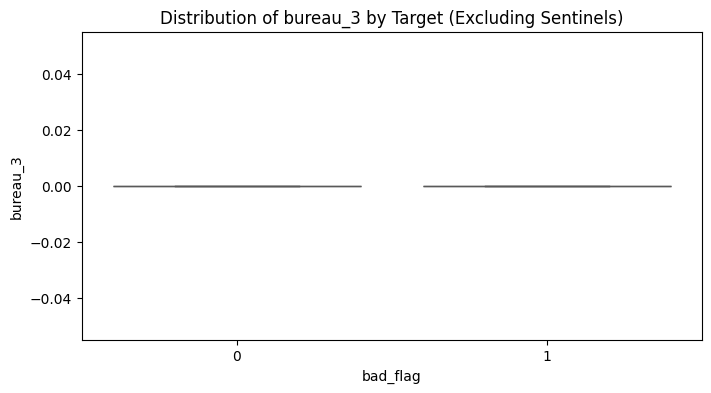

In [4]:
# Cell 4: Advanced EDA

# A. Correlation Heatmap (Sampled)
# We sample 5000 rows to keep plotting fast
df_sample = df.sample(n=min(5000, len(df)), random_state=RANDOM_STATE).select_dtypes(include=np.number)
corr = df_sample.corr()

# Show only highly correlated features (> 0.75) to justify PCA/Filtering
high_corr_cols = [c for c in corr.columns if any(corr[c].abs() > 0.9) and c != 'bad_flag']
if len(high_corr_cols) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_sample[high_corr_cols].corr(), cmap='coolwarm', center=0, annot=False)
    plt.title('High Correlation Clusters (>0.9)')
    plt.show()
else:
    print("No massive correlation clusters found.")

# B. Feature Distribution by Target
# Visualizing how a 'bureau' feature differs for Defaulters vs Payers
bureau_cols = [c for c in df.columns if 'bureau' in c.lower()][:3]
for col in bureau_cols:
    plt.figure(figsize=(8, 4))
    # Filter out the sentinel -9999 for better visualization scale
    data_filtered = df[df[col] != -9999] 
    sns.boxplot(x='bad_flag', y=col, data=data_filtered, palette='Set2', showfliers=False)
    plt.title(f'Distribution of {col} by Target (Excluding Sentinels)')
    plt.show()

In [5]:
df_c = df
# Creating a copy

Distribution of the bad_flag in the dataset
bad_flag
0    0.985827
1    0.014173
Name: count, dtype: float64


C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4244107439.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bad_flag', data=df, palette='viridis')


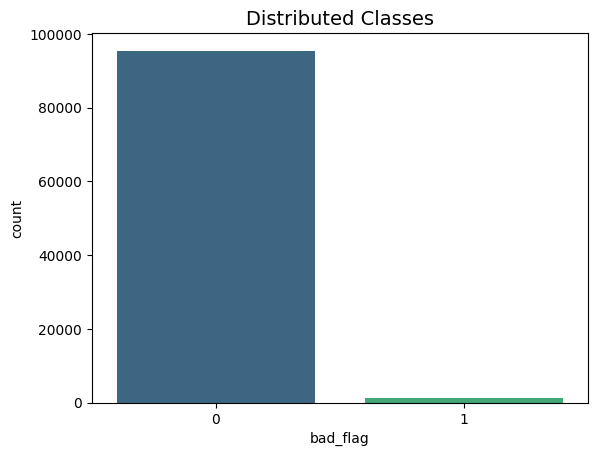

In [6]:
print('Distribution of the bad_flag in the dataset')
print(df['bad_flag'].value_counts()/len(df))

sns.countplot(x='bad_flag', data=df, palette='viridis')
plt.title('Distributed Classes', fontsize=14)
plt.show()
# The Dataset is Highly Imbalanced

In [7]:
# Cell 5: Leakage-Free Feature Selection
# CRITICAL: All selection logic happens AFTER split and ONLY on Train data

# 1. SPLIT FIRST
print("Splitting data (Stratified)...")
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, stratify=df['bad_flag'], random_state=RANDOM_STATE)

X_train_full = df_train.drop(columns=['bad_flag', 'account_number'], errors='ignore')
y_train = df_train['bad_flag']
X_test_full = df_test.drop(columns=['bad_flag', 'account_number'], errors='ignore')
y_test = df_test['bad_flag']

# 2. CORRELATION FILTER (Train Only)
def get_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    return [column for column in upper.columns if any(upper[column] > threshold)]

print("Identifying correlated features on TRAIN set...")
to_drop = get_correlated_features(X_train_full, threshold=0.9) 
print(f"Dropping {len(to_drop)} features.")

X_train_reduced = X_train_full.drop(columns=to_drop)
X_test_reduced = X_test_full.drop(columns=to_drop)

# 3. MUTUAL INFORMATION (Train Only)
print("Computing Mutual Information on TRAIN set...")
mi = mutual_info_classif(X_train_reduced.fillna(0), y_train, random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_train_reduced.columns).sort_values(ascending=False)

# Select Top K
selected_features = mi_series.head(MI_TOP_K).index.tolist()
X_train_sel = X_train_reduced[selected_features]
X_test_sel = X_test_reduced[selected_features]

print(f"Features selected via MI: {len(selected_features)}")

Splitting data (Stratified)...
Identifying correlated features on TRAIN set...
Dropping 1851 features.
Computing Mutual Information on TRAIN set...
Features selected via MI: 500


In [8]:
# Cell 6: PCA Augmentation

print("Fitting PCA on TRAIN set...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA retained {X_train_pca.shape[1]} components.")

# Create DataFrames
pca_cols = [f'pca_{i+1}' for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_cols, index=X_train_sel.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_cols, index=X_test_sel.index)

# Augment: Raw MI Features + PCA Features
X_train_final = pd.concat([X_train_sel, X_train_pca_df], axis=1)
X_test_final = pd.concat([X_test_sel, X_test_pca_df], axis=1)

# Reset index for clean stacking
X_train_final = X_train_final.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test_final = X_test_final.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Fitting PCA on TRAIN set...
PCA retained 260 components.


In [10]:
print("--- FAST Hyperparameter Optimization (RandomizedSearch) ---")
print("Note: Smaller search space for speed.")

ratio = (y_train == 0).sum() / (y_train == 1).sum()
cv_split = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# ============================
# 1. FAST TUNING: XGBoost
# ============================
print("\n1. Tuning XGBoost...")

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

xgb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

search_xgb = RandomizedSearchCV(
    xgb_base,
    xgb_params,
    n_iter=5,                   # fewer iterations (fast)
    scoring="average_precision",
    cv=cv_split,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search_xgb.fit(X_train_final, y_train)
best_xgb = search_xgb.best_estimator_
print(f"   -> Best XGB PR-AUC: {search_xgb.best_score_:.4f}")


# ============================
# 2. FAST TUNING: LightGBM
# ============================
print("\n2. Tuning LightGBM...")

lgb_base = lgb.LGBMClassifier(
    objective="binary",
    is_unbalance=True,
    verbose=-1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

lgb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400, 600],
    "num_leaves": [20, 31],
    "max_depth": [-1, 5],
    "min_child_samples": [20, 40]
}

search_lgb = RandomizedSearchCV(
    lgb_base,
    lgb_params,
    n_iter=5,                   # fast search
    scoring="average_precision",
    cv=cv_split,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search_lgb.fit(X_train_final, y_train)
best_lgb = search_lgb.best_estimator_
print(f"   -> Best LGBM PR-AUC: {search_lgb.best_score_:.4f}")


# ============================
# 3. FAST TUNING: CatBoost
# ============================
print("\n3. Tuning CatBoost...")

cat_base = CatBoostClassifier(
    loss_function="Logloss",
    auto_class_weights="Balanced",
    verbose=0,
    random_seed=RANDOM_STATE
)

cat_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [200, 400, 600],
    "depth": [4, 6],
    "l2_leaf_reg": [1, 3]
}

search_cat = RandomizedSearchCV(
    cat_base,
    cat_params,
    n_iter=5,                   # fast search
    scoring="average_precision",
    cv=cv_split,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

search_cat.fit(X_train_final, y_train)
best_cat = search_cat.best_estimator_
print(f"   -> Best CatBoost PR-AUC: {search_cat.best_score_:.4f}")


# Final Model List
models = [
    ("LightGBM", best_lgb),
    ("CatBoost", best_cat),
    ("XGBoost", best_xgb)
]


--- FAST Hyperparameter Optimization (RandomizedSearch) ---
Note: Smaller search space for speed.

1. Tuning XGBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
   -> Best XGB PR-AUC: 0.0731

2. Tuning LightGBM...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
   -> Best LGBM PR-AUC: 0.0713

3. Tuning CatBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
   -> Best CatBoost PR-AUC: 0.0685


--- Individual Model Performance ---
Training LightGBM...
  -> PR-AUC: 0.0793 | MAE: 0.2246
Training CatBoost...
  -> PR-AUC: 0.0900 | MAE: 0.3216
Training XGBoost...
  -> PR-AUC: 0.0905 | MAE: 0.3253


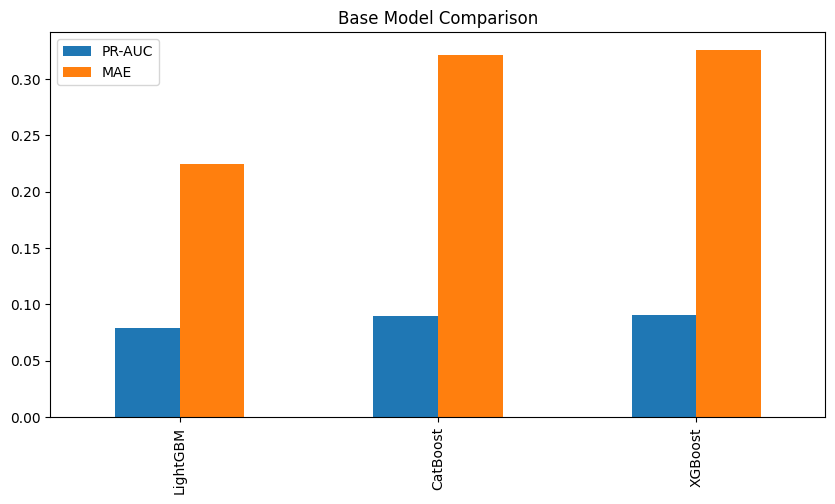

In [11]:
# Cell 8: Individual Benchmarking
# We train each model fully to see how they perform individually before stacking.

print("--- Individual Model Performance ---")
results = {}

for name, model in models:
    print(f"Training {name}...")
    m = clone_estimator(model)
    m.fit(X_train_final, y_train)
    preds = m.predict_proba(X_test_final)[:, 1]
    
    pr_auc = auc(*precision_recall_curve(y_test, preds)[1::-1]) 
    mae = mean_absolute_error(y_test, preds)
    results[name] = {'PR-AUC': pr_auc, 'MAE': mae}
    print(f"  -> PR-AUC: {pr_auc:.4f} | MAE: {mae:.4f}")

pd.DataFrame(results).T.plot(kind='bar', figsize=(10, 5), title="Base Model Comparison")
plt.show()

In [12]:
# Cell 9: Stacking (OOF Generation)

print("--- Generating Out-of-Fold (OOF) Predictions ---")
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

oof_train = pd.DataFrame(index=X_train_final.index)
oof_test = pd.DataFrame(index=X_test_final.index)

for name, model in models:
    print(f"Processing {name}...")
    train_preds = np.zeros(len(X_train_final))
    test_preds = np.zeros((len(X_test_final), N_SPLITS))
    
    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_final, y_train)):
        X_tr, y_tr = X_train_final.iloc[tr_idx], y_train.iloc[tr_idx]
        X_val, y_val = X_train_final.iloc[val_idx], y_train.iloc[val_idx]
        
        m = clone_estimator(model)
        m.fit(X_tr, y_tr)
        
        train_preds[val_idx] = m.predict_proba(X_val)[:, 1]
        test_preds[:, fold] = m.predict_proba(X_test_final)[:, 1]
        
    oof_train[name] = train_preds
    oof_test[name] = test_preds.mean(axis=1)

print("OOF Generation Complete.")

--- Generating Out-of-Fold (OOF) Predictions ---
Processing LightGBM...
Processing CatBoost...
Processing XGBoost...
OOF Generation Complete.


Training Meta-Learner (Logistic Regression)...

Learned Ensemble Weights:
      Model    Weight
0  LightGBM  0.161830
1  CatBoost  0.028631
2   XGBoost  0.809539


C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4037147826.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Weight', data=weight_df, palette='viridis')


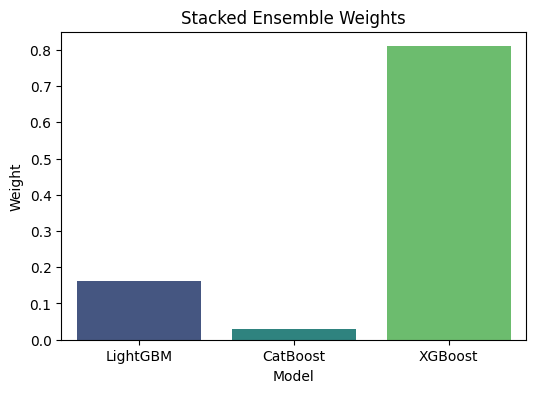

In [13]:
# Cell 10: Meta-Learner Training & Weights

print("Training Meta-Learner (Logistic Regression)...")
meta_clf = LogisticRegression(random_state=RANDOM_STATE)
meta_clf.fit(oof_train, y_train)

# Calculate Weights
coefs = np.clip(meta_clf.coef_.ravel(), 0, None)
weights = coefs / (coefs.sum() + 1e-9)

weight_df = pd.DataFrame({'Model': oof_train.columns, 'Weight': weights})
print("\nLearned Ensemble Weights:")
print(weight_df)

plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Weight', data=weight_df, palette='viridis')
plt.title('Stacked Ensemble Weights')
plt.show()

FINAL ENSEMBLE RESULTS
PR-AUC : 0.0842
MAE    : 0.0272


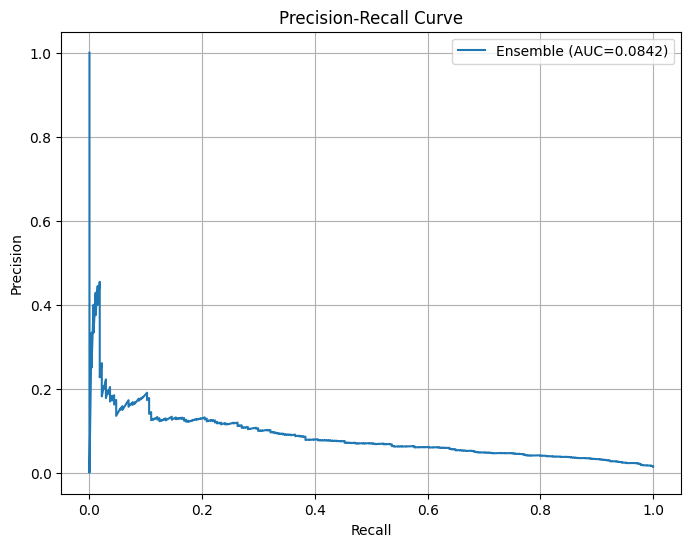

In [14]:

ensemble_preds = meta_clf.predict_proba(oof_test)[:, 1]

# Calculate Metrics
precision, recall, _ = precision_recall_curve(y_test, ensemble_preds)
pr_auc = auc(recall, precision)
mae = mean_absolute_error(y_test, ensemble_preds)

print("="*30)
print(f"FINAL ENSEMBLE RESULTS")
print(f"PR-AUC : {pr_auc:.4f}")
print(f"MAE    : {mae:.4f}")
print("="*30)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Ensemble (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np


y_val = y_test
y_pred_prob = ensemble_preds

# 1. Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

# 2. Calculate F1 score for each threshold
# Note: Precision and Recall length is len(thresholds) + 1, so we ignore the last one
fscore = (2 * precision * recall) / (precision + recall)
fscore = fscore[:-1] # Match length with thresholds

# 3. Find the index of the max F-Score
ix = np.argmax(fscore)
best_thresh = thresholds[ix]
best_fscore = fscore[ix]

print(f'Best Threshold = {best_thresh:.4f}')
print(f'Best F-Score   = {best_fscore:.4f}')

# 4. Optional: Apply this threshold to see new confusion matrix
y_pred_hard = (y_pred_prob >= best_thresh).astype(int)
print("\nConfusion Matrix with Optimal Threshold:")
print(confusion_matrix(y_val, y_pred_hard))

Best Threshold = 0.1452
Best F-Score   = nan

Confusion Matrix with Optimal Threshold:
[[19086     2]
 [  274     0]]


C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\3582059514.py:13: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


In [15]:
# Cell 12: Save Artifacts

print(f"Saving artifacts to {RESULTS_DIR}...")

# 1. Save Preprocessing
joblib.dump({'scaler': scaler, 'pca': pca}, os.path.join(RESULTS_DIR, "scaler_pca.joblib"))

# 2. Save Feature Lists
with open(os.path.join(RESULTS_DIR, "selected_features.json"), "w") as f:
    json.dump(selected_features, f)
    
with open(os.path.join(RESULTS_DIR, "to_drop_corr.json"), "w") as f:
    json.dump(to_drop, f)

# 3. Save Meta Learner
joblib.dump(meta_clf, os.path.join(RESULTS_DIR, "meta_clf.joblib"))

# 4. Save Final Full Models
for name, model in models:
    m = clone_estimator(model)
    m.fit(X_train_final, y_train)
    joblib.dump(m, os.path.join(RESULTS_DIR, f"{name}_final.joblib"))

print("All artifacts saved successfully.")

Saving artifacts to results_final_pipeline...
All artifacts saved successfully.


In [18]:
# Cell 13: Final Test Prediction

print("--- Generating Predictions for Test CSV ---")
df_deploy = pd.read_csv(r'C:\Users\aatri\Downloads\archive (1)\validation_data_to_be_shared.csv')
ids = df_deploy['account_number']

# 1. Pipeline: Optimize & Impute
df_deploy = optimize_dataframe(df_deploy)
df_deploy = sentinel_impute_with_flags(df_deploy)
if 'bad_flag_missing_flag' not in df_deploy.columns:
    df_deploy['bad_flag_missing_flag'] = 0
# 2. Pipeline: Feature Selection (Load list)
X_deploy = df_deploy.drop(columns=to_drop, errors='ignore') # Drop correlated
X_deploy = X_deploy[selected_features] # Select MI features

# 3. Pipeline: PCA
X_deploy_scaled = scaler.transform(X_deploy)
X_deploy_pca = pca.transform(X_deploy_scaled)
pca_cols = [f'pca_{i+1}' for i in range(X_deploy_pca.shape[1])]
X_deploy_pca_df = pd.DataFrame(X_deploy_pca, columns=pca_cols, index=X_deploy.index)

# 4. Pipeline: Augment
X_deploy_final = pd.concat([X_deploy.reset_index(drop=True), X_deploy_pca_df.reset_index(drop=True)], axis=1)

# 5. Predict (Ensemble)
stack_inputs = pd.DataFrame()
for name, _ in models:
    # Load the specific final model saved in Cell 12
    m = joblib.load(os.path.join(RESULTS_DIR, f"{name}_final.joblib"))
    stack_inputs[name] = m.predict_proba(X_deploy_final)[:, 1]

final_probs = meta_clf.predict_proba(stack_inputs)[:, 1]

# 6. Save
submission = pd.DataFrame({'account_number': ids, 'default_probability': final_probs})
submission.to_csv("final_submission.csv", index=False)
print("final_submission.csv saved!")

--- Generating Predictions for Test CSV ---
  -> Optimizing memory...
  -> Applying sentinel imputation...


C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4282847193.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_missing_flag"] = df[col].isna().astype(int)
C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4282847193.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_missing_flag"] = df[col].isna().astype(int)
C:\Users\aatri\AppData\Local\Temp\ipykernel_15416\4282847193.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

final_submission.csv saved!
